In [2]:
import os.path
baseDir = os.path.join('Data')
inputPath = os.path.join('projeto', 'expCorretos.txt')
fileName = os.path.join(baseDir, inputPath)
#abrir o arquivo
if os.path.isfile(fileName):
    rawData = (sc
               .textFile(fileName, 50))  


In [3]:
from collections import namedtuple
import re

#O arquivo é o log de uma aplicação sink que faz o log de um broker mqtt
#então é necessário realizar algumas manipulaçoes de pre-processamento

#função responsável por fazer o parse de cada mensagem dos sensores
def parseMessage(msg):
    msg = msg.split(";")
    for i in range(0,len(msg)):
        msg[i] = msg[i].split("=")[1]
    return msg
#depois de fazer o parse das mensagens, iremos filtar só aquelas que nos interessam
processedAllData = rawData.map(parseMessage).filter(lambda msg: msg[0]==u'poste')
processedAllData.cache()
print "cached processedAllData"
print processedAllData.take(2)

cached processedAllData
[[u'poste', u'1', u'dia', u'0.38485343993385845', u'1512616176428'], [u'poste', u'92233', u'dia', u'0.14662803797791926', u'1512616176442']]


In [4]:
#cada mensagem tem muitos atributos, não precisamos de todos eles, iremos precisar
#da informação de se é dia ou noite (filtraremos por ela) e só precisaremos do payload
processedDataDia = processedAllData.filter(lambda x: x[2]==u'dia').map(lambda x: float(x[3]))
processedDataNoite = processedAllData.filter(lambda x: x[2]=='noite').map(lambda x: float(x[3]))
processedDataDia.cache()
processedDataNoite.cache()
print "cached processedData"
print processedDataDia.take(2)
print processedDataNoite.take(2)

cached processedData
[0.38485343993385845, 0.14662803797791926]
[0.8884692653425237, 0.9028595972926372]


In [5]:
#agora que temos os dados processados, vamos calcular a media e a variancia dessa bd

#para o dia:
mediaDia = processedDataDia.mean()
varDia = processedDataDia.variance()
lenghtDia = processedDataDia.count()
print ('Mean Day: %f' %mediaDia)
print ('Var day: %f' %varDia)
print ('Lenght day: %f' %lenghtDia)

#para a noite:
mediaNoite = processedDataNoite .mean()
varNoite  = processedDataNoite .variance()
lenghtNoite  = processedDataNoite .count()
print ('Mean Night: %f' %mediaNoite)
print ('Var Night: %f' %varNoite)
print ('Lenght Night: %f' %lenghtNoite)


Mean Day: 0.208265
Var day: 0.021953
Lenght day: 12702735.000000
Mean Night: 0.697567
Var Night: 0.024837
Lenght Night: 8696659.000000


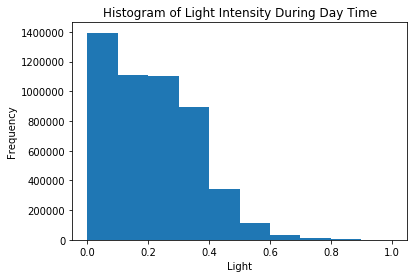

In [7]:
import plotly.plotly as py
import matplotlib.pyplot as plt
import numpy as np

dataDia = processedDataDia.take(5000000)
plt.hist(dataDia)
plt.title("Histogram of Light Intensity During Day Time")
plt.xlabel("Light")
plt.ylabel("Frequency")
fig1 = plt.gcf()
pass


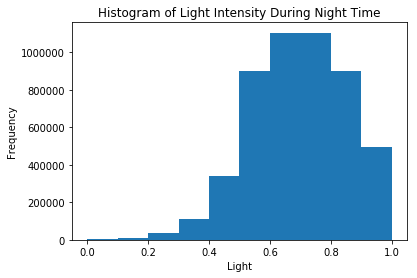

In [8]:
dataNoite = processedDataNoite.take(5000000)
plt.hist(dataNoite)
plt.title("Histogram of Light Intensity During Night Time")
plt.xlabel("Light")
plt.ylabel("Frequency")
fig2 = plt.gcf()
pass

In [45]:
#Agora faremos um processo analogo ao feito até aqui para o conjunto de dados da Cross validation
# ele será usado para ajustar o valor de epsilon, que será nosso threshold para detectar anomalias
baseDir = os.path.join('Data')
inputPath = os.path.join('projeto','crossValidation.txt')
fileName = os.path.join(baseDir, inputPath)
#abrir o arquivo
if os.path.isfile(fileName):
    rawCrossData = (sc
               .textFile(fileName, 10))

processedCrossData = rawCrossData.map(parseMessage).filter(lambda msg: msg[0]==u'poste')
crossDataDia = processedCrossData.filter(lambda x: x[2]==u'dia').map(lambda x: (float(x[3]), float(x[4])))
crossDataNoite = processedCrossData.filter(lambda x: x[2]==u'noite').map(lambda x: (float(x[3]), float(x[4])))
crossDataDia.cache()
crossDataNoite.cache()

print crossDataDia.take(1)
print crossDataNoite.take(1)

[(0.007116127474472015, 0.0)]
[(0.7785136755656221, 0.0)]


In [107]:
#Agora vamos fazer duas funções, a primeira calcula a gaussiana dado um x
#a segunda detecta se um dado elemento é uma anomalia ou não
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))


#anomalia = 1 normal = 0
def detectClassDay( x, epsilon):
    test = gaussian(x, mediaDia, varDia)
    if(test > epsilon):
        return 1.0
    else:
        return 0.0
    
def detectClassNoite( x, epsilon):
    test = gaussian(x, mediaNoite, varNoite)
    if(test > epsilon):
        return 1.0
    else:
        return 0.0

In [108]:
#Agora vamos fazer o processo de cross validation para definir um epsilon ideal para
#nosso conjunto de dados, para isso utilizaremos do f1 (Precision and recall)

def testaPrecision(pred, classe):
    if pred==classe:
        return 1.0
    else:
        return 0.0
    
def testaRecall(pred, classe):
    if pred==1.0 and classe==1.0:
        return 1.0
    else:
        return 0.0

In [104]:
from pyspark.mllib.evaluation import MulticlassMetrics
melhorF1Dia=0
melhorF1Noite=0
melhorEpsilonDia=0
melhorEpsilonNoite=0
#other (bad) epsilons tested: 1.0527717316e-70 1.0527717316e-50, 1.0527717316e-24,1.0527717316e-10,
# 1.0527717316e-5,1.0527717316e-2, 1.0527717316e-1, 1.0527717316e-5,1.0527717316e-2, 1.0527717316e-1, 0.5
#melhor 1e-30
epsilons = (1.0527717316e-50,1.0527717316e-29, 1.0527717316e-28,1.0527717316e-27,1.0527717316e-20)
for epsilon in epsilons:
    classCrossDataDia = crossDataDia.map(lambda (pred,classe): (detectClassDay(True, pred,epsilon ),classe))                                    
    classCrossDataNoite = crossDataNoite.map(lambda (pred,classe): (detectClassNoite(False, pred,epsilon ),classe))
    
    precisionDia = classCrossDataDia.map(lambda (p,c): testaPrecision(p,c)).reduce(lambda x,y: x+y)
    precisionCount = classCrossDataDia.count()
    precisionDia = precisionDia/precisionCount
    recall = classCrossDataDia.map(lambda (p,c): testaRecall(p,c)).reduce(lambda x,y: x+y)
    recallCount = classCrossDataDia.map(lambda (p,classe): classe).reduce(lambda x,y:x+y)
    recallDia = recall/recallCount
    fDia= (precisionDia*recallDia)/(precisionDia+recallDia)
    
    precisionNoite = classCrossDataNoite.map(lambda (p,c): testaPrecision(p,c)).reduce(lambda x,y: x+y)
    precisionCount = classCrossDataNoite.count()
    precisionNoite = precisionNoite/precisionCount
    recall = classCrossDataNoite.map(lambda (p,c): testaRecall(p,c)).reduce(lambda x,y: x+y)
    recallCount = classCrossDataNoite.map(lambda (p,classe): classe).reduce(lambda x,y:x+y)
    recallNoite = recall/recallCount
    fNoite= (precisionNoite*recallNoite)/(precisionNoite+recallNoite)
    
    print "DIA:"
    print "precision"
    print precisionDia
    print "recall"
    print recallDia
    print "f1"
    print fDia
    print ('-'*40)
    print "NOITE:"
    print "precision"
    print precisionNoite
    print "recall"
    print recallNoite
    print "f1"
    print fNoite
    print ('-'*40)
    
    if fDia > melhorF1Dia:
        melhorF1Dia=fDia
        melhorEpsilonDia=epsilon
    if fNoite > melhorF1Noite:
        melhorF1Noite=fNoite
        melhorEpsilonNoite=epsilon
        
    print ('Para epsilon de valor:')
    print(epsilon)
    print ('melhor epsilon: %f' %melhorEpsilonNoite)
    print ('melhor f1 dia: %f' %melhorF1Dia)
    print ('melhor f1 noite: %f' %melhorF1Noite)
    print ('-'*40)

    

DIA:
precision
0.0307652541945
recall
0.602070769067
f1
0.02926960472
----------------------------------------
NOITE:
precision
0.0116775812473
recall
0.0
f1
0.0
----------------------------------------
Para epsilon de valor:
1.0527717316e-50
melhor epsilon: 0.000000
melhor f1 dia: 0.029270
melhor f1 noite: 0.000000
----------------------------------------


KeyboardInterrupt: 

In [ ]:
#finalmente o teste final
baseDir = os.path.join('Data')
inputPath = os.path.join('projeto','test.txt')
fileName = os.path.join(baseDir, inputPath)
#abrir o arquivo
if os.path.isfile(fileName):
    rawTestData = (sc.textFile(fileName, 10))

processedTestData = rawTestData.map(parseMessage).filter(lambda msg: msg[0]==u'poste')
testDataDia = processedTestData.filter(lambda x: x[2]==u'dia').map(lambda x: (float(x[3]), float(x[4])))
testDataNoite = processedTestData.filter(lambda x: x[2]==u'noite').map(lambda x: (float(x[3]), float(x[4])))

print testDataDia.take(1)
print testDataNoite.take(1)

classTestDataDia = testDataDia.map(lambda (pred,classe): (detectClassDay(True, pred,melhorEpsilonDia ),classe))                                    
classTestDataNoite = testDataNoite.map(lambda (pred,classe): (detectClassNoite(False, pred,melhorEpsilonNoite ),classe)) 

precisionDia = classTestDataDia.map(lambda (p,c): testaPrecision(p,c)).reduce(lambda x,y: x+y)
precisionCount = classTestDataDia.count()
precisionDia = precisionDia/precisionCount
recall = classTestDataDia.map(lambda (p,c): testaRecall(p,c)).reduce(lambda x,y: x+y)
recallCount = classTestDataDia.map(lambda (p,classe): classe).reduce(lambda x,y:x+y)
recallDia = recall/recallCount
fDia= (precisionDia*recallDia)/(precisionDia+recallDia)

precisionNoite = classTestDataNoite.map(lambda (p,c): testaPrecision(p,c)).reduce(lambda x,y: x+y)
precisionCount = classTestDataNoite.count()
precisionNoite = precisionNoite/precisionCount
recall = classTestDataNoite.map(lambda (p,c): testaRecall(p,c)).reduce(lambda x,y: x+y)
recallCount = classTestDataNoite.map(lambda (p,classe): classe).reduce(lambda x,y:x+y)
recallNoite = recall/recallCount
fNoite= (precisionNoite*recallNoite)/(precisionNoite+recallNoite)

print "DIA:"
print "precision"
print precisionDia
print "recall"
print recallDia
print "f1"
print fDia
print ('-'*40)
print "NOITE:"
print "precision"
print precisionNoite
print "recall"
print recallNoite
print "f1"
print fNoite
print ('-'*40)



In [109]:
#A métrica F1 foi extremamente ruim, isso é devido a pouca variabilidade dos erros, da forma que eles foram gerados
#boa parte dos erros tem pouca diferença de valores corretos, então foi gerado um novo conjunto de dados com 
#erros maiores
baseDir = os.path.join('Data')
inputPath = os.path.join('projeto','crossValidationBigError.txt')
fileName = os.path.join(baseDir, inputPath)
#abrir o arquivo
if os.path.isfile(fileName):
    rawCrossData = (sc
               .textFile(fileName, 10))
processedCrossData = rawCrossData.map(parseMessage).filter(lambda msg: msg[0]==u'poste')
crossDataDia = processedCrossData.filter(lambda x: x[2]==u'dia').map(lambda x: (float(x[3]), float(x[4])))
crossDataNoite = processedCrossData.filter(lambda x: x[2]==u'noite').map(lambda x: (float(x[3]), float(x[4])))
crossDataDia.cache()
crossDataNoite.cache()



PythonRDD[1955] at RDD at PythonRDD.scala:48

In [112]:
melhorF1Dia=0
melhorF1Noite=0
melhorEpsilonDia=0
melhorEpsilonNoite=0
#other (bad) epsilons tested: 1.0527717316e-70 1.0527717316e-50, 1.0527717316e-24,1.0527717316e-10,
# 1.0527717316e-5,1.0527717316e-2, 1.0527717316e-1, 1.0527717316e-5,1.0527717316e-2, 1.0527717316e-1, 0.5
#melhor 1e-30 1.0527717316e-50,1.0527717316e-29, 1.0527717316e-28,1.0527717316e-27 1.0527717316e-15,1.0527717316e-7

epsilons = (1.0527717316e-10,1.0527717316e-8 )
for epsilon in epsilons:
    classCrossDataDia = crossDataDia.map(lambda (pred,classe): (detectClassDay(True, pred,epsilon ),classe))                                    
    classCrossDataNoite = crossDataNoite.map(lambda (pred,classe): (detectClassNoite(False, pred,epsilon ),classe))
    #print classCrossDataNoite.take(100)
    
    precisionDia = classCrossDataDia.map(lambda (p,c): testaPrecision(p,c)).reduce(lambda x,y: x+y)
    precisionCount = classCrossDataDia.count()
    precisionDia = precisionDia/precisionCount
    recall = classCrossDataDia.map(lambda (p,c): testaRecall(p,c)).reduce(lambda x,y: x+y)
    recallCount = classCrossDataDia.map(lambda (p,classe): classe).reduce(lambda x,y:x+y)
    recallDia = recall/recallCount
    fDia= (precisionDia*recallDia)/(precisionDia+recallDia)
    
    precisionNoite = classCrossDataNoite.map(lambda (p,c): testaPrecision(p,c)).reduce(lambda x,y: x+y)
    precisionCount = classCrossDataNoite.count()
    precisionNoite = precisionNoite/precisionCount
    recall = classCrossDataNoite.map(lambda (p,c): testaRecall(p,c)).reduce(lambda x,y: x+y)
    recallCount = classCrossDataNoite.map(lambda (p,classe): classe).reduce(lambda x,y:x+y)
    recallNoite = recall/recallCount
    print ('recall noite: %f' %recall)
    print ('recallCount noite: %f' %recallCount )
    print ('recallNoite: %f' %recallNoite)
    fNoite= (precisionNoite*recallNoite)/(precisionNoite+recallNoite)
    
    print "DIA:"
    print "precision"
    print precisionDia
    print "recall"
    print recallDia
    print "f1"
    print fDia
    print ('-'*40)
    print "NOITE:"
    print "precision"
    print precisionNoite
    print "recall"
    print recallNoite
    print "f1"
    print fNoite
    print ('-'*40)
    
    if fDia > melhorF1Dia:
        melhorF1Dia=fDia
        melhorEpsilonDia=epsilon
    if fNoite > melhorF1Noite:
        melhorF1Noite=fNoite
        melhorEpsilonNoite=epsilon
        
    print ('Para epsilon de valor:')
    print(epsilon)
    print ('melhor epsilon: %f' %melhorEpsilonNoite)
    print ('melhor f1 dia: %f' %melhorF1Dia)
    print ('melhor f1 noite: %f' %melhorF1Noite)
    print ('-'*40)

recall noite: 0.000000
recallCount noite: 39134.000000
recallNoite: 0.000000
DIA:
precision
0.36382327242
recall
0.331936809521
f1
0.173574683876
----------------------------------------
NOITE:
precision
0.288310178101
recall
0.0
f1
0.0
----------------------------------------
Para epsilon de valor:
1.0527717316e-10
melhor epsilon: 0.000000
melhor f1 dia: 0.173575
melhor f1 noite: 0.000000
----------------------------------------
recall noite: 0.000000
recallCount noite: 39134.000000
recallNoite: 0.000000
DIA:
precision
0.4215136993
recall
0.297779793991
f1
0.17450215206
----------------------------------------
NOITE:
precision
0.35007293388
recall
0.0
f1
0.0
----------------------------------------
Para epsilon de valor:
1.0527717316e-08
melhor epsilon: 0.000000
melhor f1 dia: 0.174502
melhor f1 noite: 0.000000
----------------------------------------


In [116]:
#finalmente o teste final
baseDir = os.path.join('Data')
inputPath = os.path.join('projeto','TestBigError.txt')
fileName = os.path.join(baseDir, inputPath)
#abrir o arquivo
if os.path.isfile(fileName):
    rawTestData = (sc.textFile(fileName, 10))

processedTestData = rawTestData.map(parseMessage).filter(lambda msg: msg[0]==u'poste')
testDataDia = processedTestData.filter(lambda x: x[2]==u'dia').map(lambda x: (float(x[3]), float(x[4])))
testDataNoite = processedTestData.filter(lambda x: x[2]==u'noite').map(lambda x: (float(x[3]), float(x[4] )))

print testDataDia.take(1)
print testDataNoite.take(1)

classTestDataDia = testDataDia.map(lambda (pred,classe): (detectClassDay(True, pred,melhorEpsilonDia ),classe))                                    
classTestDataNoite = testDataNoite.map(lambda (pred,classe): (detectClassNoite(False, pred,melhorEpsilonNoite ),classe)) 

precisionDia = classTestDataDia.map(lambda (p,c): testaPrecision(p,c)).reduce(lambda x,y: x+y)
precisionCount = classTestDataDia.count()
precisionDia = precisionDia/precisionCount
recall = classTestDataDia.map(lambda (p,c): testaRecall(p,c)).reduce(lambda x,y: x+y)
recallCount = classTestDataDia.map(lambda (p,classe): classe).reduce(lambda x,y:x+y)
recallDia = recall/recallCount
fDia= (precisionDia*recallDia)/(precisionDia+recallDia)

precisionNoite = classTestDataNoite.map(lambda (p,c): testaPrecision(p,c)).reduce(lambda x,y: x+y)
precisionCount = classTestDataNoite.count()
precisionNoite = precisionNoite/precisionCount
recall = classTestDataNoite.map(lambda (p,c): testaRecall(p,c)).reduce(lambda x,y: x+y)
recallCount = classTestDataNoite.map(lambda (p,classe): classe).reduce(lambda x,y:x+y)
recallNoite = recall/recallCount
fNoite= (precisionNoite*recallNoite)/(precisionNoite+recallNoite)

print "DIA:"
print "precision"
print precisionDia
print "recall"
print recallDia
print "f1"
print fDia
print ('-'*40)
print "NOITE:"
print "precision"
print precisionNoite
print "recall"
print recallNoite
print "f1"
print fNoite
print ('-'*40)


[(0.20564404834358851, 0.0)]
[(0.7702182139213366, 0.0)]
DIA:
precision
0.420872478409
recall
0.294213297543
f1
0.173162834281
----------------------------------------
NOITE:
precision
0.0200752041322
recall
1.0
f1
0.0196801216723
----------------------------------------


0.697566729763
0.0248366052321
